#### Data Split

In [16]:
import os
import shutil
import random

def split_dataset(input_dir, output_dir, split_ratio=0.8, train_limit_ratio=0.1, seed=42):
    """
    Splits the dataset into training and validation sets, with limited training data.
    
    Parameters:
    - input_dir: Directory containing the dataset.
    - output_dir: Directory to save the split datasets.
    - split_ratio: Proportion of data to use for training.
    - train_limit_ratio: Proportion of training data to actually use (e.g., 0.1 means 10% of training set).
    - seed: Random seed for reproducibility.
    """
    random.seed(seed)
    
    total_train = 0
    total_test = 0

    classes = os.listdir(input_dir)
    
    for cls in classes:
        class_path = os.path.join(input_dir, cls)
        if not os.path.isdir(class_path):
            continue
        
        images = os.listdir(class_path)
        random.shuffle(images)

        split_point = int(len(images) * split_ratio)
        train_images_full = images[:split_point]
        test_images = images[split_point:]

        # Batasi jumlah data training
        limit_point = max(1, int(len(train_images_full) * train_limit_ratio))
        train_images = train_images_full[:limit_point]

        total_train += len(train_images)
        total_test += len(test_images)

        # Create destination directories
        for phase in ['train', 'test']:
            dest_dir = os.path.join(output_dir, phase, cls)
            os.makedirs(dest_dir, exist_ok=True)

        # Copy files
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'train', cls, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'test', cls, img))
    
    print(f"Dataset split completed. Training set: {total_train} images, Validation set: {total_test} images.")


In [17]:
split_dataset('geometric_shapes_dataset', 'geometric_shapes_dataset_split', split_ratio=0.8, seed=42)

Dataset split completed. Training set: 2400 images, Validation set: 6000 images.


#### Train and Test

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    'geometric_shapes_dataset_split/train',
    target_size=(224, 224),
    class_mode='categorical',
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    'geometric_shapes_dataset_split/test',
    target_size=(224, 224),
    class_mode='categorical',
)

Found 2400 images belonging to 3 classes.
Found 6000 images belonging to 3 classes.


#### Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [20]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 tanpa top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Bekukan base model

# Tambahkan layer klasifikasi baru
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - accuracy: 0.6459 - loss: 0.7783 - val_accuracy: 0.9968 - val_loss: 0.0859
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - accuracy: 0.9930 - loss: 0.0904 - val_accuracy: 0.9992 - val_loss: 0.0269
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.9955 - loss: 0.0415 - val_accuracy: 0.9995 - val_loss: 0.0137
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.9997 - loss: 0.0206 - val_accuracy: 0.9997 - val_loss: 0.0098
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.9960 - loss: 0.0162 - val_accuracy: 0.9998 - val_loss: 0.0074


#### Evaluate

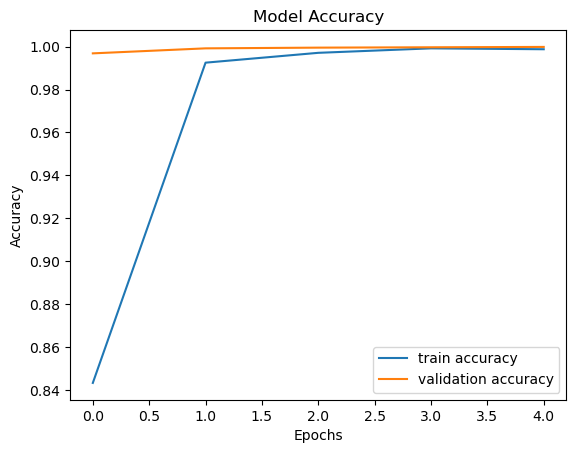

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

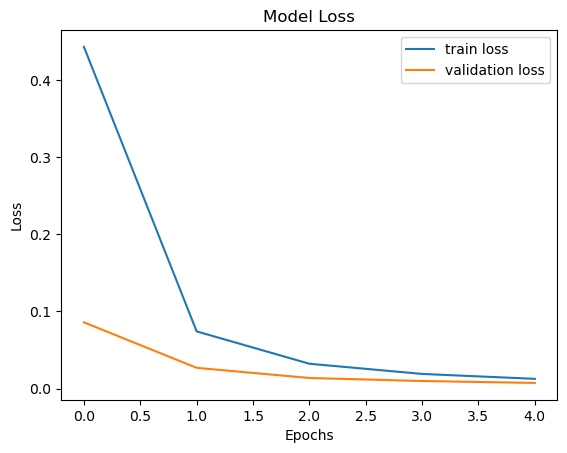

In [23]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

before transfer learning
- accuracy: 0.6301 - loss: 0.9373
Test Loss: 0.9766644239425659, Test Accuracy: 0.6358267664909363

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def view_classification_results(model, test_data, num_images=5):
    """
    Displays classification results for a few images from the test set.
    
    Parameters:
    - model: Trained Keras model.
    - test_data: Test data generator.
    - num_images: Number of images to display.
    """
    # Get label mapping
    class_labels = {v: k for k, v in test_data.class_indices.items()}

    # Fetch a batch of test data
    images, labels = next(test_data)

    # Predict
    predictions = model.predict(images[:num_images])

    # Display results
    for i in range(num_images):
        true_index = np.argmax(labels[i])
        pred_index = np.argmax(predictions[i])
        true_label = class_labels[true_index]
        pred_label = class_labels[pred_index]

        plt.imshow(images[i])
        plt.title(f"Predicted: {pred_label}, True: {true_label}")
        plt.axis('off')
        plt.show()

        print(f"Predicted: {pred_label}, True: {true_label}")
        print("____________________________________________________________")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


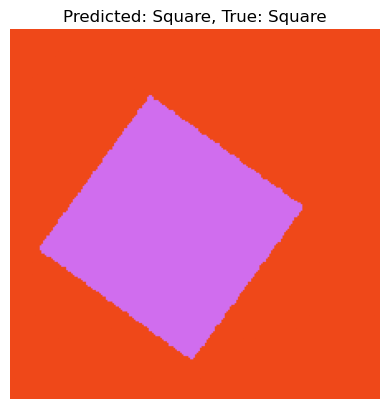

Predicted: Square, True: Square
____________________________________________________________


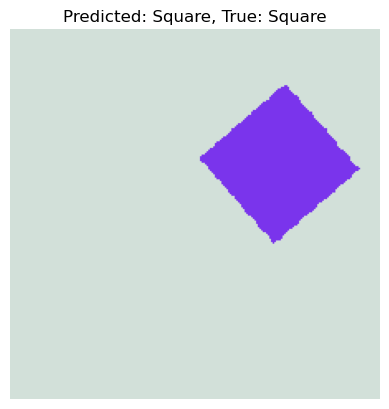

Predicted: Square, True: Square
____________________________________________________________


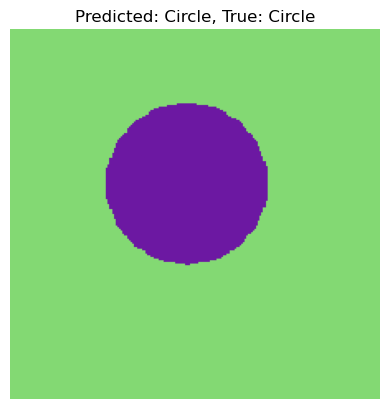

Predicted: Circle, True: Circle
____________________________________________________________


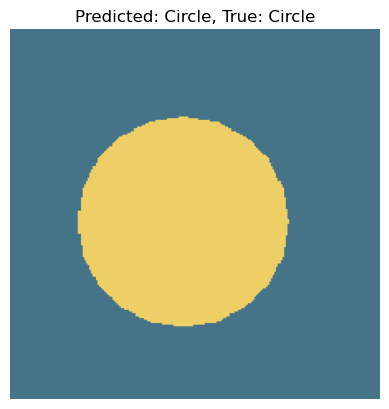

Predicted: Circle, True: Circle
____________________________________________________________


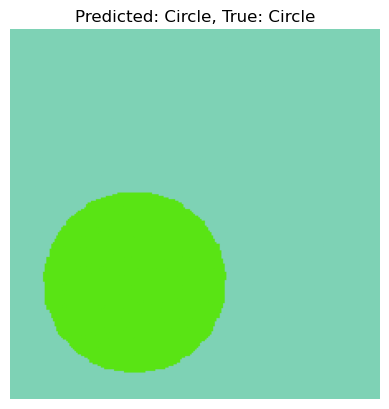

Predicted: Circle, True: Circle
____________________________________________________________


In [26]:
view_classification_results(model, test_data, num_images=5)